# RNN, LSTM
# Training language model (Many-to-Many) and generating sequences (One-to-Many)

### Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" hav been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

In [29]:
'''
TO USE TPU INSTEAD OF GPU ON GOOGLE COLAB: 17 times faster
===========================================================================
from tensorflow.keras import ... 
===========================================================================
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)
===========================================================================
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    training_model, # replace training_model 
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
===========================================================================
# compile and fit the model
tpu_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
tpu_model.fit(X_train, y_train, 
              epochs=50, 
              batch_size=64)
'''

"\nTO USE TPU INSTEAD OF GPU ON GOOGLE COLAB: 17 times fasters\n===========================================================================\nfrom tensorflow.keras import ... and Not from keras import..\n===========================================================================\n# This address identifies the TPU we'll use when configuring TensorFlow.\nTPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']\ntf.logging.set_verbosity(tf.logging.INFO)\n===========================================================================\ntpu_model = tf.contrib.tpu.keras_to_tpu_model(\n    training_model, # replace training_model \n    strategy=tf.contrib.tpu.TPUDistributionStrategy(\n        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))\n===========================================================================\n# compile and fit the model\ntpu_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])\ntpu_model.fit(X_train, y_train, \n              epo

## Import packages

In [0]:
import os
import pretty_midi
from scipy.io import wavfile 
import IPython
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import glob

In [0]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [33]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs2-5men.mid', './cs2-3cou.mid', './cs5-1pre.mid', './cs5-5gav.mid', './cs6-2all.mid', './cs1-6gig.mid', './cs4-6gig.mid', './cs4-1pre.mid', './cs3-3cou.mid', './cs3-2all.mid', './cs4-4sar.mid', './cs2-2all.mid', './cs3-6gig.mid', './cs4-3cou.mid', './cs2-4sar.mid', './cs6-6gig.mid', './cs2-1pre.mid', './cs5-2all.mid', './cs3-4sar.mid', './cs5-4sar.mid', './cs1-4sar.mid', './cs2-6gig.mid', './cs6-4sar.mid', './cs1-1pre.mid', './cs6-5gav.mid', './cs3-5bou.mid', './cs6-3cou.mid', './cs6-1pre.mid', './cs4-5bou.mid', './cs5-6gig.mid', './cs1-2all.mid', './cs5-3cou.mid', './cs1-5men.mid', './cs4-2all.mid', './cs1-3cou.mid', './cs3-1pre.mid']


## Read and convert all MIDI files

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [34]:
# We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(489, 79)
(580, 79)
(879, 79)


In [35]:
for sequence in X_list:
  print(sequence.shape)

(489, 79)
(580, 79)
(879, 79)
(1000, 79)
(936, 79)
(420, 79)
(966, 79)
(789, 79)
(984, 79)
(922, 79)
(158, 79)
(670, 79)
(644, 79)
(902, 79)
(328, 79)
(1000, 79)
(634, 79)
(372, 79)
(196, 79)
(216, 79)
(260, 79)
(690, 79)
(162, 79)
(593, 79)
(755, 79)
(872, 79)
(1000, 79)
(1000, 79)
(1000, 79)
(436, 79)
(914, 79)
(352, 79)
(642, 79)
(1000, 79)
(812, 79)
(928, 79)


## Display the set of notes over time for a specific track 

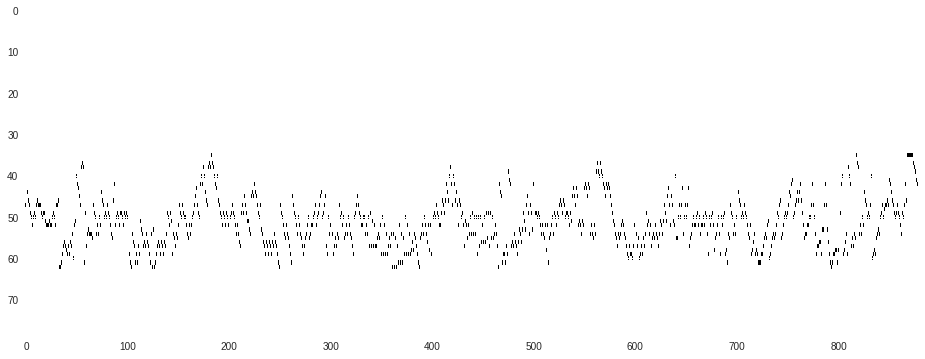

In [36]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

In [37]:
X_train_list = []
y_train_list = []

# CODE-RNN2-1

for seq in X_list:
  for n in range(len(seq)-sequence_length):
    X_train_list.append(seq[n:n+sequence_length])
    y_train_list.append(seq[n+sequence_length])

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input ```X_train``` and output ```Y_train```:  for each of the examples of sequences, we give to the network a sequence of notes of ```sequence_length``` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- a layer of ```LSTM``` with $n_a$=256
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a second layer of ```LSTM``` with $n_a$=256
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a ```Dense``` layer with 256 units
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a ``Dense``` layer with a ```softmax``` activation which predict the probability of each of the $n_x$ notes as output

Note that because we will stack two LSTM layers on top of each other (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option ```return_sequences=True``` that has to be given to the first LSTM.

This is not the case of the second LSTM since we are only interrest in its final prediction (hence ```return_sequences=False``` which is the default behaviour).

In [38]:
# create the model
K.clear_session()

model = Sequential()

''' First LSTM Layer
tell the first LSTM to output its hidden states at each time  t
input_dim / input_shape argument is required when using this as the first layer in the model
Sequences must have length and features, your input shape must contain these two: input_shape=(length, features).
Your data must also be shaped accordingly, with (sequences, length, features).
For variable lengths, you may use input_shape=(None,features)
'''
model.add(LSTM(256, return_sequences=True, input_shape=(sequence_length, n_x)))

model.add(Dropout(rate=0.3))

model.add(LSTM(256, return_sequences=True))

model.add(Dropout(rate=0.3))

model.add(LSTM(256))

model.add(Dense(units=256))

model.add(Dropout(rate=0.3))

model.add(Dense(units=79))

model.add(Activation('softmax'))

'''
To reach the expected outcome, I have added to the model :
a third LSTM layer, plus a softmax activation layer
'''

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           344064    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [39]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.60.156.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1991208873996458774)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14464666263204255696)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12729222676340202704)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5661956256990119496)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7809954055122971376)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

In [40]:
# compile and fit the model
tpu_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
tpu_model.fit(X_train, y_train, 
              epochs=50, 
              batch_size=64)

Epoch 1/50
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 20, 79), dtype=tf.float32, name='lstm_input_10'), TensorSpec(shape=(8, 79), dtype=tf.float32, name='activation_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for lstm_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7f799d62fb00> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.997598886489868 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU rho: 0.8999999761581421 {0.9}
INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}
23680/23781 [============================>.] - ETA: 0s - loss: 2.9

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 2880 sequences used for training.
We denote it by ```pattern```.



In [41]:
# --- select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]

print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

21285
(20, 79)
(1, 20, 79)


In [42]:
# Because I have issues with my batch_size when doing the predict method with the tpu_model, I'm using the CPU for the prediction
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU rho: 0.8999999761581421
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07


In [0]:
note_l = []

prediction_l = []

# generate T_y_generated notes
for note_index in range(T_y_generated):

    prediction_input = np.expand_dims(pattern, 0)
    prediction = cpu_model.predict(prediction_input)
    prediction_l.append(prediction)
    note_l.append(np.argmax(prediction))
    
    pattern = np.vstack((pattern,prediction))
    pattern = pattern[1:len(pattern),:]
    

### Display the generated sequence

[62, 61, 59, 57, 55, 54, 55, 57, 55, 54, 52, 50, 49, 47, 45, 47, 50, 52, 54, 55, 54, 52, 50, 49, 50, 52, 49, 45, 43, 42, 45, 47, 49, 50, 60, 43, 59, 52, 50, 40, 43, 45, 47, 49, 59, 42, 57, 50, 49, 38, 42, 43, 45, 47, 57, 40, 55, 49, 57, 55, 54, 52, 50, 54, 52, 50, 49, 52, 50, 52, 49, 50, 52, 50, 49, 47, 45, 47, 49, 50, 52, 54, 55, 52, 54, 52, 50, 52, 54, 52, 50, 49, 47, 49, 50, 52, 54, 56, 57, 54, 56, 54, 52, 54, 56, 54, 52, 50, 49, 59, 42, 45, 47, 49, 50, 61, 59, 57, 56, 54, 52, 62, 45, 49, 50, 52, 54, 64, 62, 61, 59, 57, 56, 66, 64, 62, 61, 59, 57, 55, 54, 52, 50, 49, 47, 45, 44, 50, 54, 52, 50, 49, 47, 45, 49, 47, 45, 44, 47, 45, 49, 47, 45, 47, 50, 49, 47, 49, 50, 52, 54, 55, 45, 38, 55, 54, 52, 50, 49, 47, 49, 50, 52, 54, 57, 56, 57, 59, 57, 56, 54, 52, 50, 49, 47, 45, 49, 47, 45, 44]


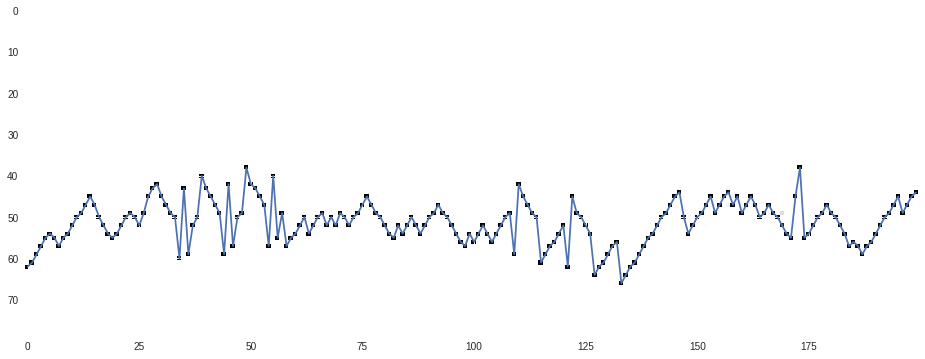

In [44]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [45]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)

Output hidden; open in https://colab.research.google.com to view.